# Build and train KMeans tabular data
## Purpose
In this example we will demonstrate how to:

   - Build a Coreset tree for KMeans clustering task on a train dataset.
   - Fit a KMeans clustering model on the root Coreset from the Coreset tree using Coreset tree's fit method
   - Compare the model's quality to a model build on the entire dataset

In this example we'll be using the well-known Covertype Dataset (https://archive.ics.uci.edu/ml/datasets/covertype). All data in the dataset will be used for the clustering task

In [1]:
import warnings
import numpy as np
import pandas as pd
from time import time
from pathlib import Path
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_covtype
from sklearn.cluster import KMeans

from dataheroes import CoresetTreeServiceKMeans

## Prepare datasets

In [2]:
# Prepare the data directory and set the names for data set files
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)

# Load Covertype dataset as a pandas data frame.
# In the output data frame all columns are features beside the last column.
# The last column (Cover_Type) is the target
df = fetch_covtype(as_frame=True).frame

# Extract features and targets from dataframe
x = df.drop(["Cover_Type"], axis=1)
y = df["Cover_Type"]

# Convert features to NumPy array
x = x.to_numpy()

## 1. Build the tree
Run `build` on the dataset features to build the tree, which will include ~581K sample. We pass `n_instances` to help the tree calculate an optimal Coreset size.

In [3]:
# Initialize the service and build the tree and time the build's duration
# The tree uses the local file system to store its data.
# After this step you will have a new directory .dataheroes_cache
coreset_build_start_time = time()
service_obj = CoresetTreeServiceKMeans(
    optimized_for='training',
    n_instances=581_012
)
service_obj.build(x)
coreset_build_time = time() - coreset_build_start_time
print(f"CoresetTreeServiceKMeans construction lasted {coreset_build_time:.2f} seconds")

CoresetTreeServiceKMeans construction lasted 5.93 seconds


## 2. Find the number of clusters by using the `elbow method`
Determine the elbow curves constructed for both the Coreset tree as well as for the full dataset. 
First, set an interval for the number of clusters the elbow method considers.

In [4]:
elbow_method_num_clusters_interval = list(range(2,13))

### 2.1. Run the `elbow method` on the Coreset tree

In [5]:
# Initialize a list of scores and fit times for the Coreset
elbow_method_scores_coreset = []
elbow_method_times_coreset = []

# Determine number of samples in the Coreset tree
num_samples_in_coreset = service_obj.get_coreset_size()

rediction_score_coreset = []
inertia_per_cluster_coreset = []
for k in elbow_method_num_clusters_interval:
    coreset_kmeans_fit_start_time = time()
    coreset_model = service_obj.fit(**{"n_clusters":k})
    coreset_kmeans_fit_time = time() - coreset_kmeans_fit_start_time
    cluster_inertia = 0
    #Predicting clusters for full dataset
    predictions_coreset = coreset_model.predict(x)
    for i, cluster_center in enumerate(coreset_model.cluster_centers_):
        #Extracting the datapoints from full dataset that belongs to a specific cluster i
        cluster_points = x[predictions_coreset == i]
        #Calculating the euclidean distance between each data points in a specific cluster and the center of that cluster
        cluster_distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
        #Taking the sum of the squared distances
        cluster_inertia+= np.sum(cluster_distances ** 2)
        inertia_per_cluster_coreset.append(cluster_inertia)
    
    elbow_method_scores_coreset.append(coreset_model.inertia_)
    elbow_method_times_coreset.append(coreset_kmeans_fit_time)


### 2.2. Run the `elbow method` on the full dataset

In [6]:
# Ignore convergence warnings for logistic regression
warnings.filterwarnings(action='ignore', category=FutureWarning)

elbow_method_scores_full_dataset = []
elbow_method_times_full_dataset = []
num_samples_in_full_dataset = len(x)

for k in elbow_method_num_clusters_interval:
    full_dataset_kmeans = KMeans(n_clusters=k)
    full_dataset_kmeans_fit_start_time = time()
    full_dataset_kmeans.fit(x)
    full_dataset_kmeans_fit_time = time() - full_dataset_kmeans_fit_start_time

    elbow_method_scores_full_dataset.append(full_dataset_kmeans.inertia_)
    elbow_method_times_full_dataset.append(full_dataset_kmeans_fit_time)    
    

## 3 Experiment results visualization
### 3.1 Visualize Coreset and full dataset clustering performance

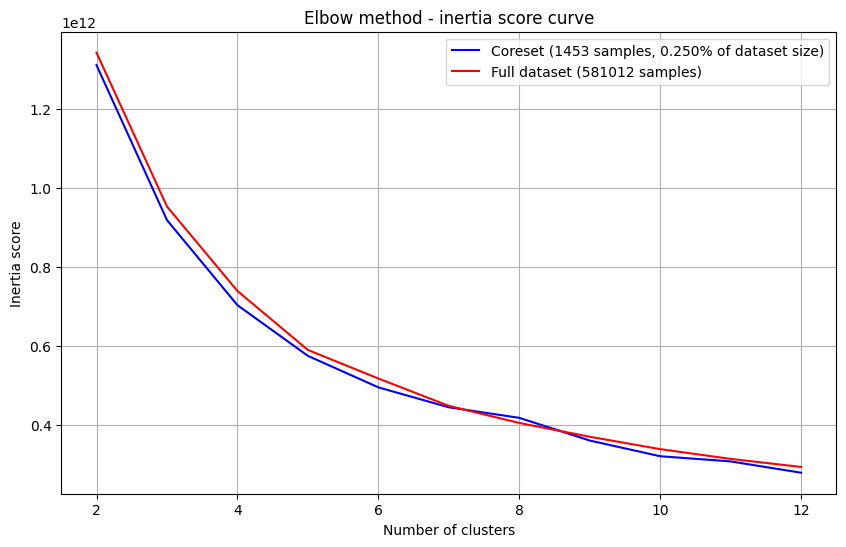

In [7]:
fig_scores, axd_scores = plt.subplots(figsize=(10, 6))

axd_scores.plot(elbow_method_num_clusters_interval, elbow_method_scores_coreset, label=f"Coreset ({num_samples_in_coreset} samples, {(num_samples_in_coreset * 100 / num_samples_in_full_dataset):.3f}% of dataset size)", color="blue")
axd_scores.plot(elbow_method_num_clusters_interval, elbow_method_scores_full_dataset, label=f"Full dataset ({num_samples_in_full_dataset} samples)", color="red")
axd_scores.grid(True)
axd_scores.ticklabel_format(useOffset=False)
axd_scores.set_ylabel('Inertia score')
axd_scores.set_xlabel("Number of clusters")
axd_scores.legend()
_ = axd_scores.set_title('Elbow method - inertia score curve')

### 3.2 Visualize the timing for fitting the clustering model on the Coreset and on the full dataset

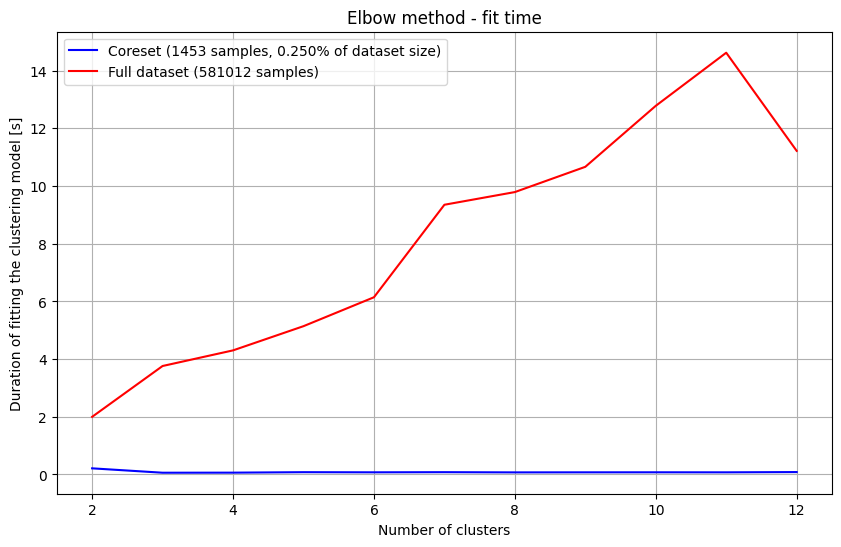

In [8]:
fig_timing, axd_timing = plt.subplots(figsize=(10, 6))
axd_timing.plot(elbow_method_num_clusters_interval, elbow_method_times_coreset, label=f"Coreset ({num_samples_in_coreset} samples, {(num_samples_in_coreset * 100 / num_samples_in_full_dataset):.3f}% of dataset size)", color="blue")
axd_timing.plot(elbow_method_num_clusters_interval, elbow_method_times_full_dataset, label=f"Full dataset ({num_samples_in_full_dataset} samples)", color="red")
axd_timing.grid(True)
axd_timing.ticklabel_format(useOffset=False)
axd_timing.set_ylabel('Duration of fitting the clustering model [s]')
axd_timing.set_xlabel("Number of clusters")
axd_timing.legend()
_ = axd_timing.set_title('Elbow method - fit time')